In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [13]:
class FastCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [16]:
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1, Loss: 0.6702
Epoch 2, Loss: 0.6177
Epoch 3, Loss: 0.5710
Epoch 4, Loss: 0.5276
Epoch 5, Loss: 0.4910


In [17]:
model.eval()
correct = 0
total = 0
misclassified = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 73.90%


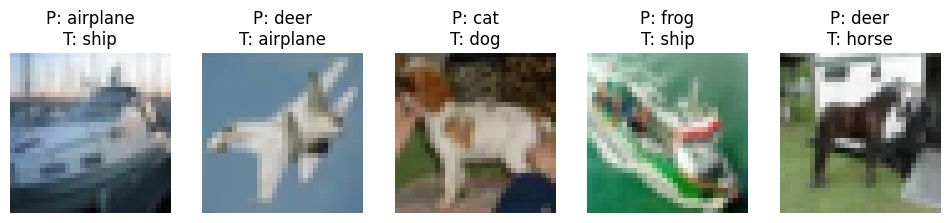

In [18]:
classes = trainset.classes
import numpy as np
plt.figure(figsize=(12, 5))
for idx, (img, pred, true) in enumerate(misclassified[:5]):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.subplot(1, 5, idx+1)
    plt.imshow(npimg)
    plt.title(f'P: {classes[pred]}\nT: {classes[true]}')
    plt.axis('off')
plt.show()